## Importing the required libraries and loading data

In [1]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (72.5 MB/s)
(Reading database ... 122518 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from

In [2]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.model_selection import train_test_split

import os
import pathlib
import librosa
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 3s 0us/step


## Pre-processing of data

In [4]:
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio


data = {
    "mapping": [],
    "labels": [],
    "MFCCs": [],
    "files": []
}


for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):


    if dirpath is not DATASET_PATH:

        label = dirpath.split("/")[-1]
        data["mapping"].append(label)
        print("\nProcessing: '{}'".format(label))

        for f in filenames:
            file_path = os.path.join(dirpath, f)

            signal, sample_rate = librosa.load(file_path)

            if len(signal) >= SAMPLES_TO_CONSIDER:

                signal = signal[:SAMPLES_TO_CONSIDER]

                num_mfcc = 13
                n_fft = 2048
                hop_length = 512
                MFCCs = librosa.feature.mfcc(y=signal, n_mfcc=num_mfcc, hop_length=hop_length, n_fft=n_fft)

                data["MFCCs"].append(MFCCs.T.tolist())
                data["labels"].append(i-1)
                data["files"].append(file_path)
                print("{}: {}".format(file_path, i-1))

# save data in json file
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)


Streaming output truncated to the last 5000 lines.
data/mini_speech_commands/no/257251e0_nohash_0.wav: 2
data/mini_speech_commands/no/2bfe70ef_nohash_0.wav: 2
data/mini_speech_commands/no/9712cce0_nohash_0.wav: 2
data/mini_speech_commands/no/8830e17f_nohash_3.wav: 2
data/mini_speech_commands/no/6c0f6493_nohash_2.wav: 2
data/mini_speech_commands/no/079d1020_nohash_0.wav: 2
data/mini_speech_commands/no/5ff3f9a1_nohash_0.wav: 2
data/mini_speech_commands/no/270bfa52_nohash_0.wav: 2
data/mini_speech_commands/no/8dc26a15_nohash_0.wav: 2
data/mini_speech_commands/no/6736bc64_nohash_1.wav: 2
data/mini_speech_commands/no/4c432947_nohash_1.wav: 2
data/mini_speech_commands/no/421ed23f_nohash_0.wav: 2
data/mini_speech_commands/no/bc065a17_nohash_0.wav: 2
data/mini_speech_commands/no/6a014b29_nohash_0.wav: 2
data/mini_speech_commands/no/2bdbe5f7_nohash_3.wav: 2
data/mini_speech_commands/no/37e8db82_nohash_0.wav: 2
data/mini_speech_commands/no/ac652c60_nohash_0.wav: 2
data/mini_speech_commands/no/b8

## Training and test of data

In [5]:
DATA_PATH = "data.json"

# generate train, validation and test sets        
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    # load dataset
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")


    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


## Model Training & testing

### DNN Model

In [7]:

def build_dnn(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_dnn(input_shape, learning_rate=0.001)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 5, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 3, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               1

In [8]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 7s 20ms/step - loss: 2.6146 - accuracy: 0.1570 - val_loss: 1.9142 - val_accuracy: 0.2507
Epoch 2/40
288/288 [==============================] - 7s 23ms/step - loss: 1.8133 - accuracy: 0.2957 - val_loss: 1.5542 - val_accuracy: 0.4578
Epoch 3/40
288/288 [==============================] - 10s 34ms/step - loss: 1.5944 - accuracy: 0.4039 - val_loss: 1.2231 - val_accuracy: 0.5492
Epoch 4/40
288/288 [==============================] - 5s 18ms/step - loss: 1.2717 - accuracy: 0.5212 - val_loss: 1.0769 - val_accuracy: 0.5909
Epoch 5/40
288/288 [==============================] - 6s 21ms/step - loss: 1.0922 - accuracy: 0.6013 - val_loss: 0.8798 - val_accuracy: 0.6606
Epoch 6/40
288/288 [==============================] - 8s 29ms/step - loss: 1.0315 - accuracy: 0.6270 - val_loss: 0.8427 - val_accuracy: 0.6736
Epoch 7/40
288/288 [==============================] - 5s 16ms/step - loss: 0.8856 - accuracy: 0.6804 - val_loss: 0.8535 - val_accuracy: 0.664

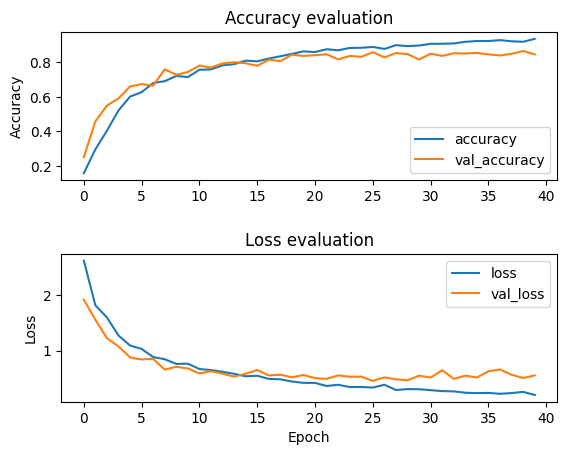

In [9]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.subplots_adjust(hspace=0.5)  # adjust spacing between subplots
    plt.show()



# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

In [10]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 0s 8ms/step - loss: 0.5282 - accuracy: 0.8614

Test loss: 0.5282009840011597, test accuracy: 86.14206314086914


## Experiment with different Learning rate

In [13]:

from tabulate import tabulate

#Array of different values of learning rate 
lr_array = [0.00001, 0.0001, 0.001, 0.01, 0.1]
result = []

for i in lr_array:
  temp = []
  model = build_dnn(input_shape, learning_rate=i)
  history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head = ["Learning Rate", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result, headers=head, tablefmt="grid"))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 5, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 3, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_4 (Dense)             (None, 256)              

## Experiment with different Batch Size

In [14]:
from tabulate import tabulate
LEARNING_RATE = 0.001
#Array of different values of learning rate 
batch_array = [16, 32, 64, 128, 256]
result1 = []

for i in batch_array:
  temp = []
  model = build_dnn(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, EPOCHS, i, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result1.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head1 = ["Batch Size", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result1, headers=head1, tablefmt="grid"))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 21, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 19, 3, 64)         18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_24 (Dense)            (None, 256)              

## Experiment with different Epoch value

In [15]:
from tabulate import tabulate

#Array of different values of learning rate 
epoch_array = [20, 30, 40, 50, 60]
result2 = []

for i in epoch_array:
  temp = []
  model = build_dnn(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, i, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result2.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head2 = ["Epoch", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result2, headers=head2, tablefmt="grid"))



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 21, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 19, 3, 64)         18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 9, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 576)               0         
                                                                 
 dense_44 (Dense)            (None, 256)             

## Experiment with different PATIENCE VALUE

In [16]:
from tabulate import tabulate

#Array of different values of learning rate 
patience_array = [3, 4, 5, 6, 7]
result3 = []

for i in patience_array:
  temp = []
  model = build_dnn(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, EPOCHS, BATCH_SIZE, i, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result3.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head3 = ["Patience", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result3, headers=head3, tablefmt="grid"))



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 21, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 19, 3, 64)         18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 9, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 576)               0         
                                                                 
 dense_64 (Dense)            (None, 256)             